# *grama* Model-Building Demo

---

*grama* is a *grammar of model analysis*---a language for describing and analyzing mathematical models. Heavily inspired by [ggplot](https://ggplot2.tidyverse.org/index.html), `py_grama` is a Python package that implements *grama* by providing tools for defining and exploring models. 

This notebook illustrates how one can use *grama* to ___build a fully-defined model___.

Note that you will need to install `py_grama`, a fork of `dfply`, and dependencies in order to run this notebook. See the [installation instructions](https://github.com/zdelrosario/py_grama) for details. 

In [1]:
### Setup
import grama as gr
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

X = gr.Intention()

from grama.data import df_stang


# Overview

---

To demonstrate building a *grama* model, we will build a plate buckling model accounting for variable material properties and uncertain loads. A *grama* model has both functions and distributions. We recommend first choosing the relevant functions, identifiying all their inputs (variables), determining which are deterministic or random, then choosing a distribution. We illustrate all of these steps below.

Note: I make no claim that the modeling choices below are optimal or even imitable; this document is primarily a demonstration of ***a fully reproducible model-building exercise***. Since all choices made here (bad or good) are documented, the resulting model's provenance is easily traceable.


# Function

---


Peery [1] gives a simple model for the buckling stress of a plate under compression

$$\sigma_{\text{buckle}} = \frac{12E}{\pi} \frac{(t/h)^2}{1 - \mu^2},$$

where

| Symbol | Variable |
|-----|-----------|
| $t$ | Thickness |
| $h$ | Height |
| $E$ | Elasticity |
| $\mu$ | Poisson's ratio |
| $\sigma_{\text{buckle}}$ | Buckling stress |

We formulate this as a reliability problem by additionally considering the imposed load $L$. To compute stress, we need the width of the plate $w$ as well; vis. $\sigma = L / t / w$. Then the *limit state* is given by

$$g_{\text{buckle}} = \sigma_{\text{buckle}} - \frac{L}{t w}.$$

This function is encoded below.


In [2]:
def function_buckle_state(x):
    t, h, w, E, mu, L = x
    return np.pi * E / 12 / (1 - mu**2) * (t / h)**2 - L / t / w

buckle_vars = ["t", "h", "w", "E", "mu", "L"]

This is the only function we consider, so we now have the full list of variables for the model.


# Variables

---

Now that we have a full list of variables, we must decide which are *random* and which are *deterministic*.

| Var | Type  | Rationale |
|-----|-------|-----------|
| $t$ | `det` | Chosen |
| $h$ | `det` | Chosen |
| $w$ | `det` | Chosen |
| $L$ | `det` | Chosen |
| $E$ | `rand` | Material property |
| $\mu$ | `rand` | Material property |

In this study we choose $t,h,w,L$ to be deterministic. If we were interested in comparing manufacturing variability with other sources of uncertainty, we would need to make them random.

### Deterministic Bounds

While not required, it is helpful to give deterministic bounds for the inputs. This provides the user some context on what values are relevant to the problem at hand.

In [3]:
t_bounds = [0.125, 0.5]
h_bounds = [10, 12]
w_bounds = [2, 3]
L_bounds = [0.5, 2.0]

### Random Variables

Since we have random variables, we must fit a *distribution* to describe their randomness. This ideally results from a principled, data-driven analysis. We provide an example of such a study below.

# Distribution

---

## Choosing Marginals with EDA

The following data describe the elasticity `E` and Poisson ratio `mu` of an aluminum alloy, tested at different angles [2]. A tidied version of these data are provided with `py_grama`.


In [4]:
df_stang.describe()

,thick,E,mu,ang
count,76.000000,76.000000,76.000000,76.000000
mean,0.051395,10344.736842,0.321461,45.000000
std,0.024349,260.458435,0.006582,37.469988
min,0.022000,9900.000000,0.310000,0.000000
25%,0.032000,10075.000000,0.315750,0.000000
50%,0.064000,10400.000000,0.322000,45.000000
75%,0.081000,10500.000000,0.328000,90.000000
max,0.081000,10700.000000,0.331000,90.000000


We inspect the bivariate relation between `E,mu` to assess dependence and choose marginals.

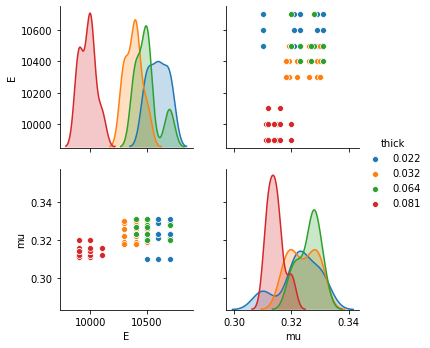

In [5]:
sns.pairplot(df_stang, vars=["E", "mu"], hue="thick")


The thickest plates seem to be quite different from the others. I would be inclied to return to [2] and see if anything was strange about these thickest samples.

If we remove the largest plates, do the marginals look closer to standard distributions?

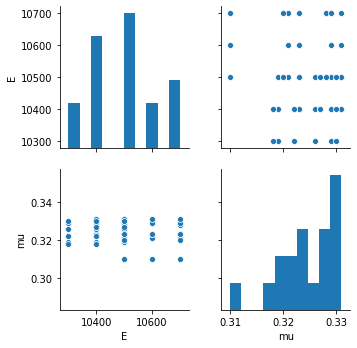

In [6]:
df_filtered = \
    df_stang >> \
    gr.tf_filter(X.thick < 0.08)
sns.pairplot(df_filtered, vars=["E", "mu"])


With filtered thick plates `E` looks roughly normal. Values of Poisson ratio `mu` are extremely constrained and essentially have compact support; I choose to fit a beta distribution.


## Fitting Marginals

Now that we have selected marginal shapes, we can use the data to fit parameters for the marginals. We use utility `marg_` functions to fit different kinds of distributions.

For `E`, we choose to fit a normal distribution; this is a `named` distribution, so we use `marg_named()` and specify the name of the distribution to fit. These names are taken from the [scipy list of continuous distributions](https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats).

In [7]:
mg_E = gr.marg_named(df_filtered.E, "norm")
mg_E.summary()

"(+0) norm, {'loc': 10494.444444444445, 'scale': 122.34841969747357}"

From this summary, we can see the fitted normal distribution has parameters of mean (`loc`) and standard deviation (`scale`).

For `mu` we instead elect to fit a *kernel density estimate*, which does not take a specific shape, and instead smoothes the data to form an estimated density.

In [8]:
mg_mu = gr.marg_gkde(df_filtered.mu)
mg_mu.summary()

'(+0) gaussian KDE n=54, f=4.503e-01, b=[2.999e-01, 3.415e-01]'

From this summary, we can see the fitted KDE relies on `n` data points, has a bandwidth parameter of `f`, and quantile bounds of `b`. 

We can pass this information to the model building interface, or use the `marg_` calls in-place.

## Fitting a copula

From the pair plots above, we can see that the `E, mu` variables might exhibit some mild dependence. We can further investigate this with a *Gaussian copula*, which is easily incorporated in our model build. Below we build a model for the random variables only, and compare drawing samples from this model against the original data.

In [9]:
## Fit the copula
md_tmp = gr.Model() >>\
    gr.cp_marginals(E=mg_E, mu=mg_mu) >> \
    gr.cp_copula_gaussian(df_data=df_filtered)
md_tmp.printpretty()

model: None

  inputs:
    var_det:
    var_rand:
      E: (+0) norm, {'loc': 10494.444444444445, 'scale': 122.34841969747357}
      mu: (+0) gaussian KDE n=54, f=4.503e-01, b=[2.999e-01, 3.415e-01]
    copula:
        Gaussian copula with correlations:
  var1 var2      corr
0   mu    E -0.045926
  functions:


Printing the model summary above shows that the fitted copula has a correlation of about `-0.04`, which seems negligible. Below we visualize and compare the original samples against samples drawn from the fitted distribution.

Design runtime estimates unavailable; model has no timing data.


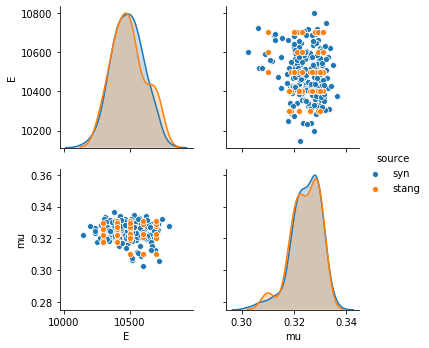

In [10]:
## Compare samples
df_syn = md_tmp >> gr.ev_monte_carlo(n=200, df_det="nom", skip=True)
df_both = pd.concat(
    (df_syn.assign(source=["syn"] * df_syn.shape[0]),
     df_filtered.assign(source=["stang"] * df_filtered.shape[0])),
    axis=0,
    sort=False
).reset_index(drop=True)
df_both

sns.pairplot(df_both, vars=["E", "mu"], hue="source")

# `py_grama` Model Definition

---

With the information above, we can build our `py_grama` model. Using a sequence of compositions, we build up the model using the information described above. A final call to `printpretty()` allows us to summarize the model.

In [11]:
md_plate = \
    gr.Model("Plate Buckling") >> \
    gr.cp_function(
        fun=function_buckle_state,
        var=buckle_vars,
        out=["g_buckle"]
    ) >> \
    gr.cp_bounds(
        t=t_bounds,
        w=w_bounds,
        h=h_bounds,
        L=L_bounds
    ) >> \
    gr.cp_marginals(
        E=mg_E,
        mu=mg_mu
    ) >> \
    gr.cp_copula_gaussian(df_data=df_filtered)

md_plate.printpretty()


model: Plate Buckling

  inputs:
    var_det:
      h: [10, 12]
      w: [2, 3]
      L: [0.5, 2.0]
      t: [0.125, 0.5]
    var_rand:
      E: (+0) norm, {'loc': 10494.444444444445, 'scale': 122.34841969747357}
      mu: (+0) gaussian KDE n=54, f=4.503e-01, b=[2.999e-01, 3.415e-01]
    copula:
        Gaussian copula with correlations:
  var1 var2      corr
0   mu    E -0.045926
  functions:
    function_buckle_state: ['t', 'h', 'w', 'E', 'mu', 'L'] -> ['g_buckle']


The method `printpretty()` allows us to summarize the model. We can check that the correct variables are sorted into deterministic (`det`) or random (`rand`) categories, and that the correct distributions and parameters are assigned for each marginal.

With a fully defined model, we can carry out various kinds of model analyses, for instance a Monte Carlo analysis is now a one-line call. The [analysis demo](https://github.com/zdelrosario/py_grama/blob/master/examples/demo/analysis_demo.ipynb) has more details on model analysis with `py_grama`.

In [12]:
df_mc = md_plate >> gr.ev_monte_carlo(n=1e3, df_det="nom")
df_mc.describe()

eval_monte_carlo() is rounding n...


,mu,E,h,w,L,t,g_buckle
count,1000.000000,1000.000000,1000.0,1000.0,1000.00,1000.0000,1000.000000
mean,0.323980,10493.671980,11.0,2.5,1.25,0.3125,0.877392
std,0.006091,125.015968,0.0,0.0,0.00,0.0000,0.030847
min,0.303592,9946.617292,11.0,2.5,1.25,0.3125,0.743587
25%,0.320329,10408.027337,11.0,2.5,1.25,0.3125,0.856374
50%,0.324582,10491.153054,11.0,2.5,1.25,0.3125,0.876962
75%,0.328479,10576.937386,11.0,2.5,1.25,0.3125,0.898173
max,0.338162,10889.145887,11.0,2.5,1.25,0.3125,0.965770


# Bibliography

---

[1] David J Peery. Aircraft structures. Courier Corporation, 2011.

[2] A. H. Stang, M. Greenspan, and S. B. Newman, Journal of Research of the National Bureau of Standards 37, (1946).
